# Author
David Jorge

# Overview


This notebook trains and tests the object detection model for the Ocean Pollution and Forecasting project. At the end it gives the option to convert the output model into a tflite format for use in an embedded device (in this case a raspberry pi).

***Made for running in Google Colab***

# 1. Import Data

## Prepare Data

The data labelling and pre-processing is all done using the RoboFlow service.
Roboflow also allows to export the pre-processed dataset in different formats, which will be neccessary for training and testing. 2 formats of the input dataset will be needed: TFRecord format and COCO format, which will be done in the 2 cells below.

In [ ]:
# Main Training and Test Set

# Downloading data from Roboflow
# Replace the last line with the one that Roboflow provides when exporting the dataset.
# THIS NEEDS TO BE IN TFRecord FORMAT
%mkdir /content/train/
%cd /content/train/
!curl -L "https://app.roboflow.com/ds/Y0ynMliyVP?key=Cixu20N53q" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/train
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0    954      0 --:--:-- --:--:-- --:--:--   953
100  551k  100  551k    0     0   410k      0  0:00:01  0:00:01 --:--:-- 2715k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/Garbage.tfrecord   
 extracting: test/Garbage_label_map.pbtxt  
   creating: train/
 extracting: train/Garbage.tfrecord  
 extracting: train/Garbage_label_map.pbtxt  
   creating: valid/
 extracting: valid/Garbage.tfrecord  
 extracting: valid/Garbage_label_map.pbtxt  


In [ ]:
#Inference Test Set

# downloading test images from Roboflow
# Replace the last line with the one that Roboflow provides when exporting the dataset.
# THIS NEEDS TO BE IN COCO FORMAT
%mkdir /content/test/
%cd /content/test/
!curl -L "https://app.roboflow.com/ds/s1XJX5jP3Z?key=ezqDAli9Ws" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0    955      0 --:--:-- --:--:-- --:--:--   954
100  566k  100  566k    0     0   374k      0  0:00:01  0:00:01 --:--:-- 86.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/orange-bag-f_png.rf.ea2da10fa6331d83e44b58c5fc4d9ecf.jpg  
   creating: train/
 extracting: train/PE-bags-sunk-f_png.rf.857d02ec6e79791f3516942015bea641.jpg  
 extracting: train/PE-bags-sunk-f_png.rf.99e89c5f9852d26aa2fb38c48b04de2c.jpg  
 extracting: train/PE-bags-sunk-f_png.rf.fd46b138c68f184f70c58e46c9d3e8d9.jpg  
 extracting: train/_annotations.coco.json  
 extracting: train/bottle_f_png.rf.1e5d6affe2c5dff45c3afb35172cc3e2.jpg  
 extracting: train/bottle_f_png.rf.500b62cfebcaf035c8a6987a6feb910c.jpg  
 extracting: train

# 2. Train

_This notebook will train a MobileNetSSDv2. TensorFlow Lite is independent of the model used, so a simple and lightweight solution is chosen._

## **Training MobileNetSSD Object Detection on a Custom Dataset**

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which this notebook is based. 

### **The Model**

A MobileNetSSDv2 (single shot detector) will be trained. This specific model is a one-short learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant for mobile hardware.

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

As a note, this notebook presumes TensorFlow 1.5 as TensorFlow 2.0 has yet to fully support the object detection API.

### **Training**

Google Colab provides free GPU resources. Click "Runtime" → "Change runtime type" → Hardware Accelerator dropdown to "GPU."

Colab does have memory limitations, and notebooks must be open in your browser to run. Sessions automatically clear themselves after 12 hours.

### **Inference**

Inference is ran directly in this notebook. 







## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 200000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Model architecture picked
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Clone the `tensorflow-object-detection` repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
     |████████████████████████████████| 352 kB 4.2 MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to un

## Prepare `tfrecord` files

Roboflow automatically creates the TFRecord and label_map files necessary.

**Generating your own TFRecords the only step you need to change for another custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
!cp -r /content/train/train/ /content/tensorflow-object-detection-faster-rcnn/data/
!cp -r /content/train/test/ /content/tensorflow-object-detection-faster-rcnn/data/

In [ ]:
# training set
%ls train

Garbage_label_map.pbtxt  Garbage.tfrecord


In [ ]:
# test set
%ls test

Garbage_label_map.pbtxt  Garbage.tfrecord


In [ ]:
# NOTE: Update these TFRecord names from "Garbage" and "Garbage_label_map" to your own files if another custom dataset is being used.
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Garbage.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Garbage.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/Garbage_label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 23 root   root  4.0K Aug 26 12:59 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [ ]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-08-26 12:59:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.198.191.45, 34.227.155.46, 3.222.79.56, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.198.191.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.48MB/s    in 2.0s    

2021-08-26 12:59:33 (6.48 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


## Train the model

Install LVIS API necessary for training the model

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# install LVIS API
!pip install lvis

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-esslsc0s
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-esslsc0s
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263923 sha256=2c739ef5a81c2ffa615ab6e33613650a0a94fe88d3343d7b352bff382006c591
  Stored in directory: /tmp/pip-ephem-wheel-cache-awq6vepg/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0826 12:59:55.231513 140047917590400 model_lib.py:817] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 200000
I0826 12:59:55.231787 140047917590400 config_util.py:552] Maybe overwriting train_steps: 200000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0826 12:59:55.231958 140047917590400 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0826 12:59:55.232102 140047917590400 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0826 12:59:55.232252 140047917590400 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0826 12:59:55.232434 140047917590400 model_lib.py:833] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_

In [ ]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1629982815.971ea08f807b
graph.pbtxt
model.ckpt-27600.data-00000-of-00001
model.ckpt-27600.index
model.ckpt-27600.meta
model.ckpt-29130.data-00000-of-00001
model.ckpt-29130.index
model.ckpt-29130.meta
model.ckpt-30651.data-00000-of-00001
model.ckpt-30651.index
model.ckpt-30651.meta
model.ckpt-32204.data-00000-of-00001
model.ckpt-32204.index
model.ckpt-32204.meta
model.ckpt-33762.data-00000-of-00001
model.ckpt-33762.index
model.ckpt-33762.meta


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This is done again for TFLite. 

In [ ]:
%cd /content/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research
training/model.ckpt-33762
Instructions for updating:
Please use `layer.__call__` method instead.
W0826 16:45:09.451634 139678101501824 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0826 16:45:11.994491 139678101501824 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0826 16:45:12.042915 139678101501824 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0826 16:45:12.091257 139678101501824 convolutional_box_predictor.py:156] depth of additional conv before box predict

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file (for other use)

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
# !ls -alh {pb_fname}

### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# fname = os.path.basename(pb_fname)
# # Create & upload a text file.
# uploaded = drive.CreateFile({'title': fname})
# uploaded.SetContentFile(pb_fname)
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
# from google.colab import files
# files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
# from google.colab import files
# files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
# files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test

In [ ]:
!cp -r /content/test/test/ /content/tensorflow-object-detection-faster-rcnn/

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/test/_annotations.coco.json', '/content/tensorflow-object-detection-faster-rcnn/test/orange-bag-f_png.rf.ea2da10fa6331d83e44b58c5fc4d9ecf.jpg']


In [ ]:
!ls /content/tensorflow-object-detection-faster-rcnn/

data			    requirements.txt
deploy			    resize_images.py
generate_tfrecord.py	    tensorflow_object_detection_training_colab.ipynb
LICENSE			    test
local_inference_test.ipynb  Tutorial_Faster_RCNN.ipynb
local_inference_test.py     Tutorial_Mobilenet.ipynb
README.md		    xml_to_csv.py


In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

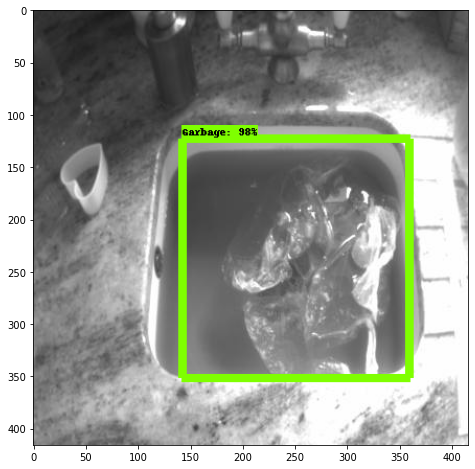

In [ ]:
# Limited displayed images to 5 to reduce memory
count = 5
for i, image_path in enumerate(TEST_IMAGE_PATHS):
    if i > count:
        break
    if image_path[-1]=="n":
      continue
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# 3. Convert

Convert trained model to .tflite format.

In [ ]:
%ls /content/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [ ]:
!tflite_convert \
  --input_shape=1,300,300,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model.tflite"

2021-08-26 16:45:37.177484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-26 16:45:37.183010: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-26 16:45:37.183656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2021-08-26 16:45:37.183929: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-08-26 16:45:37.185639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-08-26 16:45:37.187450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change the final TFLite destination here
!cp /content/models/research/fine_tuned_model/final_model.tflite "/content/drive/My Drive/"

The tflite model will now be in your google drive. Alternatively it will also be at '/content/models/research/fine_tuned_model/final_model.tflite' in this Google Colab session.